In [42]:
import os
import cv2
from torchvision import transforms
from PIL import Image
import torch
from torch import nn, optim
from tqdm.auto import tqdm
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pickle
from ModelBaseline import ModelBaseline

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train_dataset = []
test_dataset = []

root = "/Users/pavlom/Desktop/dataset/"

for folder in os.listdir(root):
    if folder != ".DS_Store":
        for face_part in os.listdir(root + "/" + folder):
            if face_part != ".DS_Store":
                for filename in os.listdir(root + folder + "/" + face_part):   
                    if filename != ".DS_Store":
                        f = os.path.join(root + folder + "/" + face_part, filename)
                        if os.path.isfile(f):
                            label = 0 # В случае, если рассматриваем глаза.
                            if face_part == "mouths":
                                label = 1
                            elif face_part == "noses":
                                label = 2
                            img = Image.open(root + folder + "/" + face_part + "/" + filename)
                            img = img.resize((100,100),Image.ANTIALIAS)
                            img = transforms.ToTensor()(img)
                            if folder == "test":
                                test_dataset.append(tuple([img, label]))
                            else:
                                train_dataset.append(tuple([img, label]))

In [3]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True, 
    num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False, 
    num_workers=4
)

In [4]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

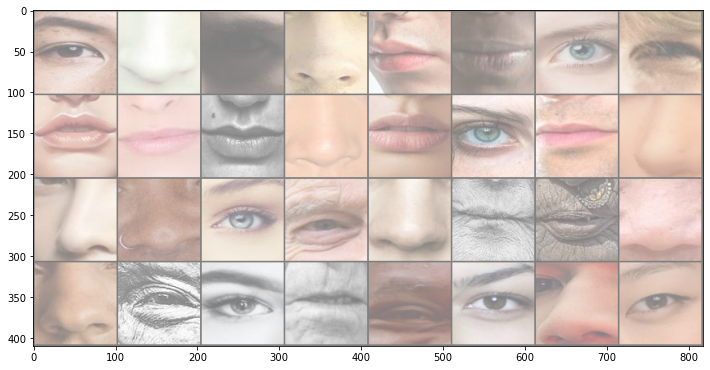

In [22]:
images, labels = next(iter(train_dataloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(25 * 25 * 32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        # x: (batch_size, n_channels, height, width)
        x = self.vgg(x)
        return x


In [64]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [65]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    for epoch in range(n_epochs):
        # тренировка
        train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.train()
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels.cpu()).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])


        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0)))

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0)
                ))
        
        
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:", 
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:", 
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )

Training, epoch 0:   0%|          | 0/449 [00:32<?, ?it/s]

Validating, epoch 0:   0%|          | 0/107 [00:23<?, ?it/s]

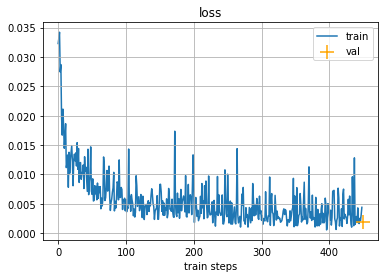

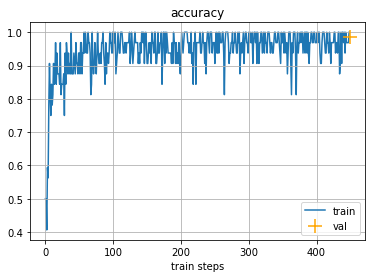

Train loss: 0.005566778127104044
Train acc: 0.944668710231781
Val loss: 0.001913378364406526
Val acc: 0.985397219657898


Training, epoch 1:   0%|          | 0/449 [00:28<?, ?it/s]

Validating, epoch 1:   0%|          | 0/107 [00:23<?, ?it/s]

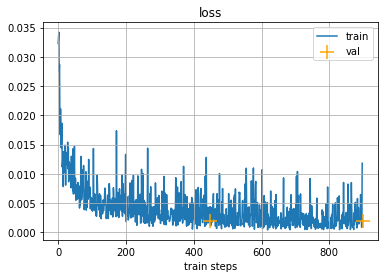

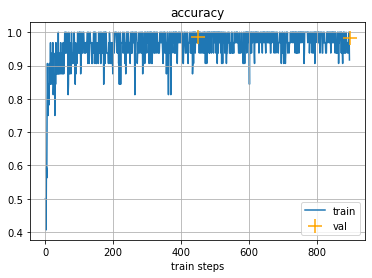

Train loss: 0.0026629071217030287
Train acc: 0.9741787314414978
Val loss: 0.0019580922089517117
Val acc: 0.9836448431015015


Training, epoch 2:   0%|          | 0/449 [00:07<?, ?it/s]

Validating, epoch 2:   0%|          | 0/107 [00:05<?, ?it/s]

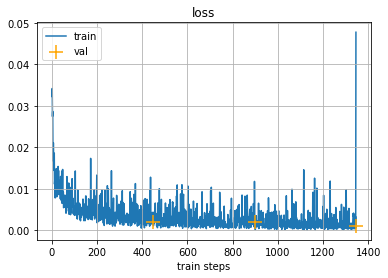

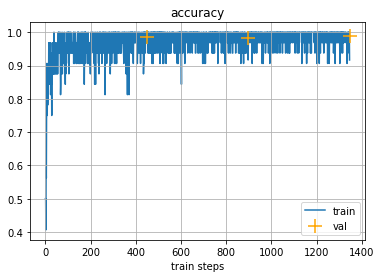

Train loss: 0.0019639364909380674
Train acc: 0.9823914170265198
Val loss: 0.0011678687296807766
Val acc: 0.9891939163208008


Training, epoch 3:   0%|          | 0/449 [00:29<?, ?it/s]

Validating, epoch 3:   0%|          | 0/107 [00:25<?, ?it/s]

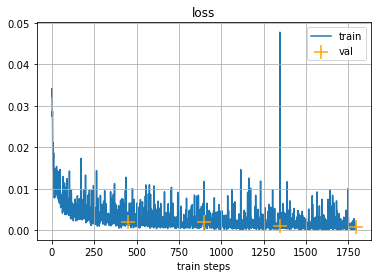

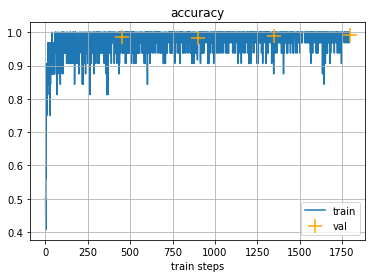

Train loss: 0.001575625385157764
Train acc: 0.9842010140419006
Val loss: 0.0007971099112182856
Val acc: 0.992698609828949


Training, epoch 4:   0%|          | 0/449 [00:30<?, ?it/s]

Validating, epoch 4:   0%|          | 0/107 [00:25<?, ?it/s]

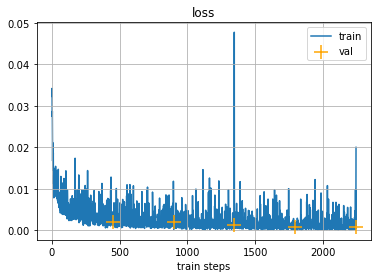

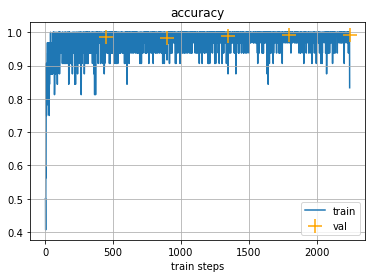

Train loss: 0.001408396870829165
Train acc: 0.9864977598190308
Val loss: 0.0007705730968154967
Val acc: 0.9929906725883484


In [70]:
model_baseline = ModelBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)

train(model_baseline, criterion, optimizer, train_dataloader, val_dataloader, n_epochs = 5)

In [71]:
with open("face_part_classifier.pickle", "wb") as outfile:
    pickle.dump(model_baseline, outfile)
print("Written object", model_baseline)

Written object ModelBaseline(
  (vgg): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, i

In [91]:
bright_thres = 0.5
dark_thres = 0.4
frame = cv2.imread("/Users/pavlom/Desktop/FaceExtraction/images/test_images/light.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
dark_part = cv2.inRange(gray, 0, 30)
bright_part = cv2.inRange(gray, 220, 255)
# use histogram
# dark_pixel = np.sum(hist[:30])
# bright_pixel = np.sum(hist[220:256])
total_pixel = np.size(gray)
dark_pixel = np.sum(dark_part > 0)
bright_pixel = np.sum(bright_part > 0)
if dark_pixel/total_pixel > bright_thres:
    print("Face is underexposed!")
if bright_pixel/total_pixel > dark_thres:
    print("Face is overexposed!")

Face is overexposed!


In [98]:
img = cv2.imread("/Users/pavlom/Desktop/FaceExtraction/images/predicted_images/right_eye.jpg")
img = transforms.ToTensor()(img)
model_baseline(img.unsqueeze(0))

<class 'numpy.ndarray'>


tensor([[ 0.9517,  1.8440, -3.6459]], grad_fn=<AddmmBackward0>)